Dự đoán giá BTC

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

##### Import dataset and preprocess

In [3]:
# Chuẩn bị dữ liệu

path ="Bitcoin Historical Data.csv"
data = pd.read_csv(path)

df = data[['Date', 'Price']]

# Group by Date và tính tổng Revenue
grouped_df = df.groupby('Date').sum().reset_index()

# Chuyển đổi cột 'Date' thành kiểu datetime với định dạng 'dd/mm/yyyy'
grouped_df['Date'] = pd.to_datetime(grouped_df['Date'], format='%m/%d/%Y')

# Sắp xếp DataFrame theo cột 'Date'
df_sorted = grouped_df.sort_values(by='Date')
df_sorted['Price'] = df_sorted['Price'].str.replace(',', '').astype(float)

# In ra kết quả
print(df_sorted)
data = df_sorted

           Date    Price
1664 2013-03-01     34.5
1796 2013-03-02     34.3
1928 2013-03-03     34.5
1964 2013-03-04     36.2
1976 2013-03-05     40.3
...         ...      ...
2647 2024-05-28  68366.0
2659 2024-05-29  67635.8
2683 2024-05-30  68354.7
2695 2024-05-31  67530.1
2779 2024-06-01  67760.8

[4111 rows x 2 columns]


Phân chia dữ liệu

In [4]:
# Scaler data
price = data['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

price_scaled = scaler.fit_transform(price)


# Chia dữ liệu thành train test validate
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

Xây dựng thuật toán

In [5]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [6]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [7]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1])
X_train, y_train

(array([[2.73852558e-06, 0.00000000e+00, 2.73852558e-06, ...,
         7.10647387e-04, 7.69525687e-04, 7.92803155e-04],
        [0.00000000e+00, 2.73852558e-06, 2.60159930e-05, ...,
         7.69525687e-04, 7.92803155e-04, 8.03757257e-04],
        [2.73852558e-06, 2.60159930e-05, 8.21557673e-05, ...,
         7.92803155e-04, 8.03757257e-04, 9.54376164e-04],
        ...,
        [2.57073612e-01, 2.62111129e-01, 2.63439314e-01, ...,
         5.55441450e-01, 5.49315369e-01, 5.22481926e-01],
        [2.62111129e-01, 2.63439314e-01, 2.65645197e-01, ...,
         5.49315369e-01, 5.22481926e-01, 4.86225216e-01],
        [2.63439314e-01, 2.65645197e-01, 2.91898072e-01, ...,
         5.22481926e-01, 4.86225216e-01, 4.66121700e-01]]),
 array([0.00080376, 0.00095438, 0.00114607, ..., 0.48622522, 0.4661217 ,
        0.5113909 ]))

In [8]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50)

In [9]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])
test_predict

array([[36259.814],
       [36259.814],
       [36259.814],
       ...,
       [36259.814],
       [36259.814],
       [36259.814]])

Dự báo 30 ngày kế

In [10]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = data['Price'].values[-30:]
next_30_days = []

for i in range(30):
    x = last_30_days[-time_step:].reshape(1, time_step)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

[[36259.814]
 [36177.492]
 [36309.736]
 [36403.81 ]
 [36578.284]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]
 [36607.648]]


Vẽ đồ thị

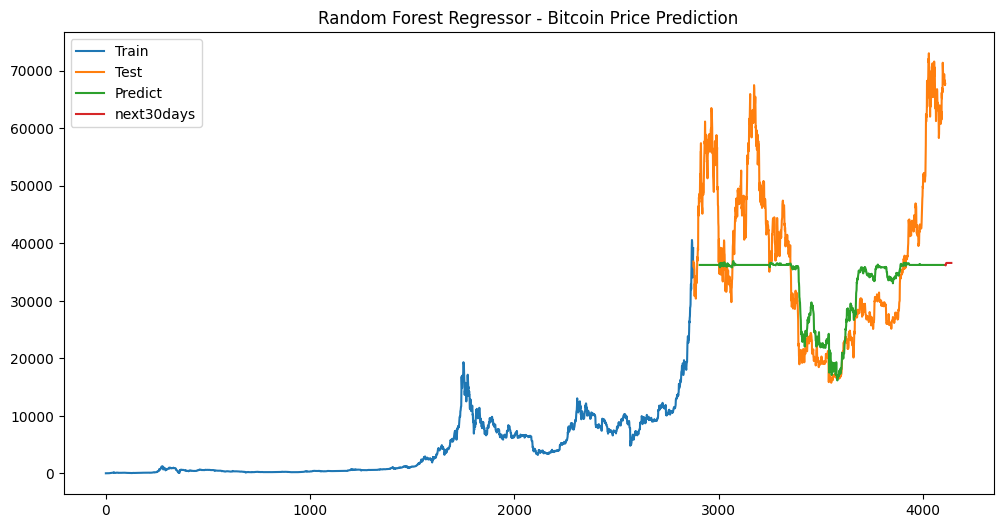

In [11]:
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))

# train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Train")
# plt.plot([*train_range], pred_train.squeeze(), label="Predict Train", linestyle="dotted", color = color_palette[1])

# test
test_data_index = pd.RangeIndex(start=len(data) - len(test_data), stop=len(data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Test")

test_data_index = pd.RangeIndex(start=train_size+31, stop=len(data), step=1)
plt.plot(test_data_index, test_predict.squeeze(), label="Predict", linestyle="-")

#30 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
plt.plot(predict_data_index, next_30_days.squeeze(), label="next30days")


# # Dự đoán 30 điểm tiếp theo
plt.legend()
plt.title('Random Forest Regressor - Bitcoin Price Prediction')
plt.show()

In [12]:
# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_mae = mean_absolute_error(y_test[0], test_predict[:, 0])


print('RMSE:', test_score_rmse)
print('MAPE:', test_score_mape)
print(f'MAE: {test_mae}')

RMSE: 12633.962594805747
MAPE: 21.5461485874883
MAE: 9224.654975893596


## NASDAQ

In [13]:
# Chuẩn bị dữ liệu

path ="NASDAQ Composite Historical Data.csv"
data = pd.read_csv(path)

df = data[['Date', 'Price']]

# Group by Date và tính tổng Revenue
grouped_df = df.groupby('Date').sum().reset_index()

# Chuyển đổi cột 'Date' thành kiểu datetime với định dạng 'dd/mm/yyyy'
grouped_df['Date'] = pd.to_datetime(grouped_df['Date'], format='%m/%d/%Y')

# Sắp xếp DataFrame theo cột 'Date'
df_sorted = grouped_df.sort_values(by='Date')
df_sorted['Price'] = df_sorted['Price'].str.replace(',', '').astype(float)

# In ra kết quả
print(df_sorted)
data = df_sorted

           Date     Price
1133 2013-03-01   3169.74
1342 2013-03-04   3182.03
1351 2013-03-05   3224.13
1359 2013-03-06   3222.37
1368 2013-03-07   3232.09
...         ...       ...
1789 2024-05-24  16920.79
1815 2024-05-28  17019.88
1822 2024-05-29  16920.58
1838 2024-05-30  16737.08
1846 2024-05-31  16735.02

[2833 rows x 2 columns]


Phân chia dữ liệu

In [14]:
# Scaler data
price = data['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

price_scaled = scaler.fit_transform(price)


# Chia dữ liệu thành train test validate
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

Xây dựng thuật toán

In [15]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [16]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [17]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1])
X_train, y_train

(array([[2.43981313e-04, 1.13112047e-03, 4.17005931e-03, ...,
         9.44814026e-03, 9.65819517e-03, 9.28211747e-03],
        [1.13112047e-03, 4.17005931e-03, 4.04301578e-03, ...,
         9.65819517e-03, 9.28211747e-03, 3.61857492e-03],
        [4.17005931e-03, 4.04301578e-03, 4.74464252e-03, ...,
         9.28211747e-03, 3.61857492e-03, 7.09350403e-03],
        ...,
        [6.40340506e-01, 6.44460036e-01, 6.52504923e-01, ...,
         6.96761545e-01, 6.91118936e-01, 7.14700668e-01],
        [6.44460036e-01, 6.52504923e-01, 6.51991696e-01, ...,
         6.91118936e-01, 7.14700668e-01, 7.24409392e-01],
        [6.52504923e-01, 6.51991696e-01, 6.63279080e-01, ...,
         7.14700668e-01, 7.24409392e-01, 7.12459361e-01]]),
 array([0.00361857, 0.0070935 , 0.00276536, ..., 0.72440939, 0.71245936,
        0.71505798]))

In [18]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50)

In [19]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])
test_predict

array([[13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13078.0962],
       [13078.0962],
       [13059.254 ],
       [13083.2604],
       [13078.1204],
       [13091.5452],
       [13078.191 ],
       [13053.6312],
       [13080.179 ],
       [13025.1682],
       [13072.91  ],
       [13064.9532],
       [13075.1984],
       [13083.1614],
       [13067.3604],
       [13065.5504],
       [13086.5714],
       [13085.1314],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082.5404],
       [13082

Dự báo 30 ngày kế

In [20]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = data['Price'].values[-30:]
next_30_days = []

for i in range(30):
    x = last_30_days[-time_step:].reshape(1, time_step)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

[[13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]
 [13082.5404]]


Vẽ đồ thị

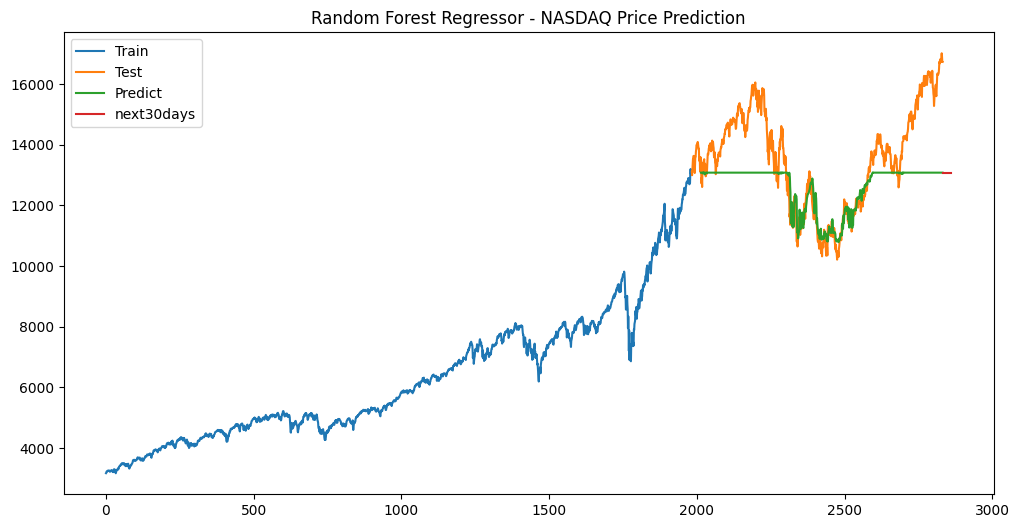

In [21]:
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))

# train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Train")
# plt.plot([*train_range], pred_train.squeeze(), label="Predict Train", linestyle="dotted", color = color_palette[1])

# test
test_data_index = pd.RangeIndex(start=len(data) - len(test_data), stop=len(data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Test")

test_data_index = pd.RangeIndex(start=train_size+31, stop=len(data), step=1)
plt.plot(test_data_index, test_predict.squeeze(), label="Predict", linestyle="-")

#30 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
plt.plot(predict_data_index, next_30_days.squeeze(), label="next30days")


# # Dự đoán 30 điểm tiếp theo
plt.legend()
plt.title('Random Forest Regressor - NASDAQ Price Prediction')
plt.show()

In [22]:
# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_mae = mean_absolute_error(y_test[0], test_predict[:, 0])


print('RMSE:', test_score_rmse)
print('MAPE:', test_score_mape)
print(f'MAE: {test_mae}')

RMSE: 1443.40513847577
MAPE: 7.093395149274319
MAE: 1047.6015992673974


## USD

In [23]:
# Chuẩn bị dữ liệu

path ="US Dollar Index Futures Historical Data.csv"
data = pd.read_csv(path)

df = data[['Date', 'Price']]

# Group by Date và tính tổng Revenue
grouped_df = df.groupby('Date').sum().reset_index()

# Chuyển đổi cột 'Date' thành kiểu datetime với định dạng 'dd/mm/yyyy'
grouped_df['Date'] = pd.to_datetime(grouped_df['Date'], format='%m/%d/%Y')

# Sắp xếp DataFrame theo cột 'Date'
df_sorted = grouped_df.sort_values(by='Date')
# df_sorted['Price'] = df_sorted['Price'].str.replace(',', '').astype(float)

# In ra kết quả
print(df_sorted)
data = df_sorted

           Date    Price
1168 2013-03-01   82.358
1377 2013-03-04   82.255
1386 2013-03-05   82.147
1394 2013-03-06   82.507
1403 2013-03-07   82.123
...         ...      ...
1852 2024-05-27  104.638
1860 2024-05-28  104.539
1869 2024-05-29  105.034
1887 2024-05-30  104.658
1896 2024-05-31  104.627

[2907 rows x 2 columns]


Phân chia dữ liệu

In [24]:
# Scaler data
price = data['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

price_scaled = scaler.fit_transform(price)


# Chia dữ liệu thành train test validate
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

Xây dựng thuật toán

In [25]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [26]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [27]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1])
X_train, y_train

(array([[0.09255176, 0.08960225, 0.08650955, ..., 0.10045531, 0.09160677,
         0.09392629],
        [0.08960225, 0.08650955, 0.09681853, ..., 0.09160677, 0.09392629,
         0.09681853],
        [0.08650955, 0.09681853, 0.08582228, ..., 0.09392629, 0.09681853,
         0.07723147],
        ...,
        [0.36124395, 0.36270439, 0.34652501, ..., 0.3048309 , 0.31276309,
         0.32347298],
        [0.36270439, 0.34652501, 0.3415137 , ..., 0.31276309, 0.32347298,
         0.31264855],
        [0.34652501, 0.3415137 , 0.32985882, ..., 0.32347298, 0.31264855,
         0.32038029]]),
 array([0.09681853, 0.07723147, 0.10495118, ..., 0.31264855, 0.32038029,
        0.31680078]))

In [28]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50)

In [29]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])
test_predict

array([[ 91.00636],
       [ 91.11774],
       [ 91.03352],
       [ 91.06576],
       [ 91.79164],
       [ 92.0224 ],
       [ 92.46988],
       [ 92.06904],
       [ 91.9547 ],
       [ 91.80904],
       [ 91.90938],
       [ 91.91744],
       [ 91.91216],
       [ 91.8124 ],
       [ 91.96676],
       [ 91.95078],
       [ 91.9004 ],
       [ 92.4156 ],
       [ 92.59136],
       [ 92.82414],
       [ 92.9241 ],
       [ 93.01318],
       [ 93.3657 ],
       [ 93.17814],
       [ 93.0889 ],
       [ 93.30256],
       [ 92.68918],
       [ 92.40064],
       [ 92.42072],
       [ 92.19784],
       [ 92.37926],
       [ 92.34974],
       [ 91.85984],
       [ 91.72158],
       [ 91.73046],
       [ 91.71628],
       [ 91.16956],
       [ 91.38984],
       [ 91.40142],
       [ 91.58598],
       [ 91.01464],
       [ 90.9487 ],
       [ 90.96496],
       [ 90.59816],
       [ 90.60364],
       [ 91.3473 ],
       [ 90.8337 ],
       [ 91.36534],
       [ 91.61936],
       [ 90.8175 ],


Dự báo 30 ngày kế

In [30]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = data['Price'].values[-30:]
next_30_days = []

for i in range(30):
    x = last_30_days[-time_step:].reshape(1, time_step)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

[[102.50366]
 [101.9998 ]
 [101.64428]
 [101.53494]
 [101.37314]
 [100.9445 ]
 [100.75232]
 [100.27244]
 [100.11224]
 [ 99.92234]
 [ 99.93384]
 [ 99.85174]
 [ 99.86224]
 [ 99.87796]
 [ 99.92008]
 [ 99.93386]
 [ 99.92296]
 [ 99.89184]
 [ 99.96324]
 [ 99.98452]
 [ 99.91458]
 [ 99.8218 ]
 [ 99.86326]
 [ 99.80838]
 [ 99.83438]
 [ 99.86256]
 [ 99.82058]
 [ 99.7898 ]
 [ 99.8875 ]
 [ 99.91508]]


Vẽ đồ thị

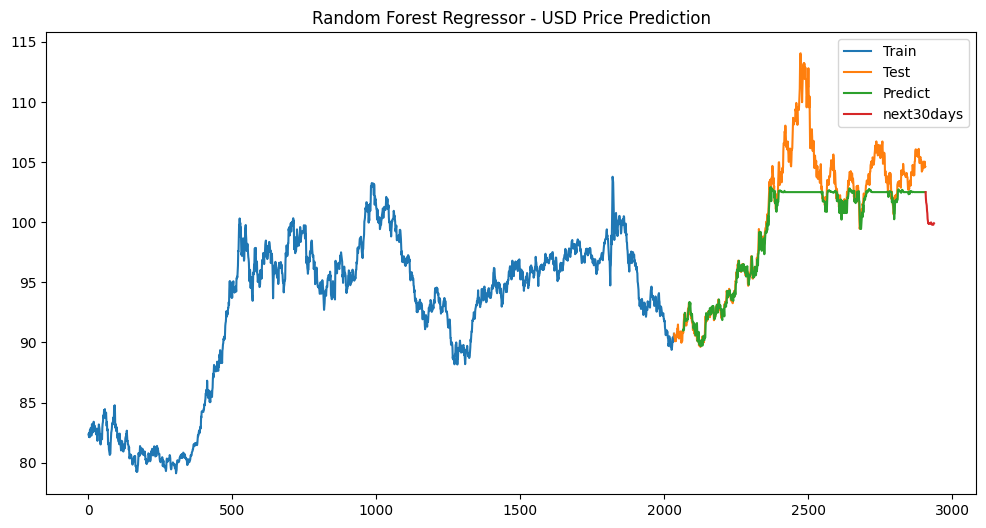

In [31]:
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))

# train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Train")
# plt.plot([*train_range], pred_train.squeeze(), label="Predict Train", linestyle="dotted", color = color_palette[1])

# test
test_data_index = pd.RangeIndex(start=len(data) - len(test_data), stop=len(data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Test")

test_data_index = pd.RangeIndex(start=train_size+31, stop=len(data), step=1)
plt.plot(test_data_index, test_predict.squeeze(), label="Predict", linestyle="-")

#30 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
plt.plot(predict_data_index, next_30_days.squeeze(), label="next30days")


# # Dự đoán 30 điểm tiếp theo
plt.legend()
plt.title('Random Forest Regressor - USD Price Prediction')
plt.show()

In [32]:
# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_mae = mean_absolute_error(y_test[0], test_predict[:, 0])


print('RMSE:', test_score_rmse)
print('MAPE:', test_score_mape)
print(f'MAE: {test_mae}')

RMSE: 2.70547961130291
MAPE: 1.496279664596129
MAE: 1.5909594061757695
